<a href="https://colab.research.google.com/github/sherif17/Random-Search-Optimization-Techniques/blob/main/TSP_AntColony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports**

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### **Custom Data Structure for AntColony**

In [2]:
class City:
    def __init__(self, n, x, y):
        self.name = n
        self.x = x
        self.y = y
        
    def __repr__(self):
        return 'City: ' + str(self.name) + ' ' + str(self.x) + ' ' + str(self.y) + '\n'

In [3]:
class Path:
    def __init__(self, lst):
        self.val = lst
        self.fitness = -1
        self.cost = -1
    
    def set_fitness(self,cost):
        self.cost = cost
        self.fitness = 1.0/cost

    def __repr__(self):
        print(self.val)
        print(self.cost)
        return ''

### **Ant Colony Helper functions**

In [4]:
def cost(path, mat):
    # path -> object of Path
    total_cost = 0
    lst = path.val
    for i, gene in enumerate(lst):
        if i == 0:
            continue
        total_cost += mat[gene.name][lst[i-1].name]
        
    total_cost += mat[lst[0].name][lst[-1].name]
    return total_cost

In [5]:
def initial_pop(lst_cities, n, dist_mat):  
    # n -> population size
    # lst_cities -> list of objects
    generation = []
    for i in range(n):
        crom = lst_cities.copy()
        random.shuffle(crom)
        c = Path(crom)
        f = cost(c, dist_mat)
        c.set_fitness(cost = f)
        generation.append(c)
    return generation

In [6]:
def gen_dist_matrix(data):
    # data -> list of City objects
    n = len(data)
    mat = {} ##  Dic <first city, Dic <second city, distance> >
    for i,point in enumerate(data): # point -> city
        key = point.name
        mat[key] = {}
        for j in range(n):
            # distination city
            p2 = data[j]
            c = p2.name
            mat[key][c] = math.dist([point.x , point.y], [p2.x, p2.y])
            
    return mat

In [13]:
def initial_phromone_matrix(data, initial_pop):  
    # data -> list of City objects
    n = len(data)
    phormone_mat = {} ##  Dic <first city, Dic <second city, phormone> >
    
    for i,point in enumerate(data): # point -> city
        key = point.name
        phormone_mat[key] = {}
    
    for i,point in enumerate(data): # point -> city
        key = point.name
        for j in range(n):
            # distination city
            p2 = data[j]
            c = p2.name
            r = random.random()
            phormone_mat[key][c] = 0.0001
    
    phormone_mat = update_phromone_matrix(phormone_mat, initial_pop, roo = 0.9999)
    return phormone_mat

In [7]:
def update_phromone_matrix(phormone_mat, gen, roo = 0.5):
    new_phormone_mat = {}
    # divide all matrix by (1-roo)
    for key, dic in phormone_mat.items():
        nw = {key: val*(1-roo) for key, val in dic.items()}
        new_phormone_mat[key] = nw
    
    # sum each partial path to the matrix
    for ant in gen:  # object of path
        lst = ant.val
        path_fit = ant.fitness
        for i, gene in enumerate(lst):
            if i == 0:
                continue
            new_phormone_mat[lst[i].name][lst[i-1].name] += path_fit
            new_phormone_mat[lst[i-1].name][lst[i].name] += path_fit

            new_phormone_mat[lst[0].name][lst[-1].name] += path_fit
        new_phormone_mat[lst[-1].name][lst[0].name] += path_fit
    return new_phormone_mat

In [8]:
def construction(data, dist_mat, phormone_mat):
    alpha = 1
    beta = 2
    n = len(data)
    gen = []
    for i in range(n): # for 1 sol in population
        vis = {}
        # random start
        start = random.randint(0,n-1)
        city = data[start] # object
        sol = [city]
        vis[city.name] = 1
        
        while len(vis) < n:
            p_city_all = {}
            p_sum = 0
            # calculate next step
            for c in data:
                if c.name not in vis:
                    p = (phormone_mat[city.name][c.name] ** alpha) * ((1.0/dist_mat[city.name][c.name])** beta)
                    p_city_all[c.name] = p
                    p_sum += p
            
            # divide by sum
            for c in p_city_all:
                p_city_all[c] /= p_sum

            # select max p
            selected = max(p_city_all, key = p_city_all.get) # key -> city name
            
            # find the city
            selected_city = None
            for c in data:
                if c.name == selected:
                    selected_city = c
                    
            # append selected city
            sol.append(selected_city)
            vis[selected_city.name] = 1
            city = selected_city
        
        # append solution
        s = Path(sol)
        f = cost(s, dist_mat)
        s.set_fitness(f)
        gen.append(s)
    return gen 

### **Reading Dataset**

In [10]:
# input from file
raw = pd.read_csv('/content/15-Points.csv')
raw

,x,y,City
0,5.500000e-08,9.860000e-09,1
1,-2.887330e+01,-7.980000e-08,2
2,-7.929160e+01,-2.140330e+01,3
3,-1.465770e+01,-4.338960e+01,4
4,-6.474730e+01,2.189820e+01,5
5,-2.905850e+01,-4.321670e+01,6
6,-7.207850e+01,1.815810e-01,7
7,-3.603660e+01,-2.161350e+01,8
8,-5.048080e+01,7.374470e+00,9
9,-5.058590e+01,-2.158820e+01,10


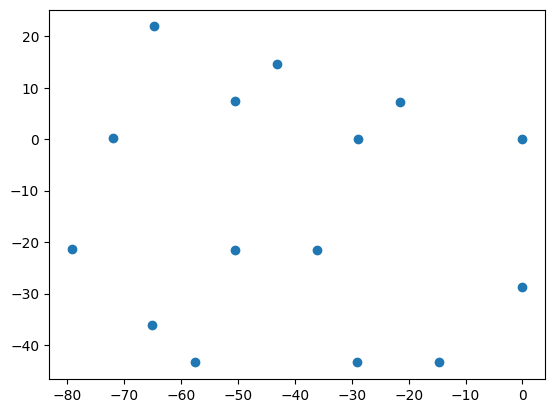

In [11]:
plt.scatter(raw['x'], raw['y'], marker = 'o')

In [12]:
data = [City(c,x,y) for c,x,y in zip(raw['City'], raw['x'], raw['y'])]
print(data[0])

City: 1 5.5e-08 9.86e-09



### **Initial population**

In [14]:
n = len(data)
pop_n = 200

dist_mat = gen_dist_matrix(data)
gen = initial_pop(data, pop_n, dist_mat)  ## list of chromosomes
phormone_mat = initial_phromone_matrix(data, gen)

initial_gen = gen

In [23]:
best = max(gen, key = lambda x: x.fitness)
best

[City: 1 5.5e-08 9.86e-09
, City: 13 -21.4983 7.31942
, City: 2 -28.8733 -7.98e-08
, City: 15 -43.07 14.5548
, City: 9 -50.4808 7.37447
, City: 5 -64.7473 21.8982
, City: 7 -72.0785 0.181581
, City: 3 -79.2916 -21.4033
, City: 12 -65.0866 -36.0625
, City: 14 -57.5687 -43.2506
, City: 10 -50.5859 -21.5882
, City: 8 -36.0366 -21.6135
, City: 6 -29.0585 -43.2167
, City: 4 -14.6577 -43.3896
, City: 11 -0.135819 -28.7293
]
284.3810904080332


### **Running Algorthim**

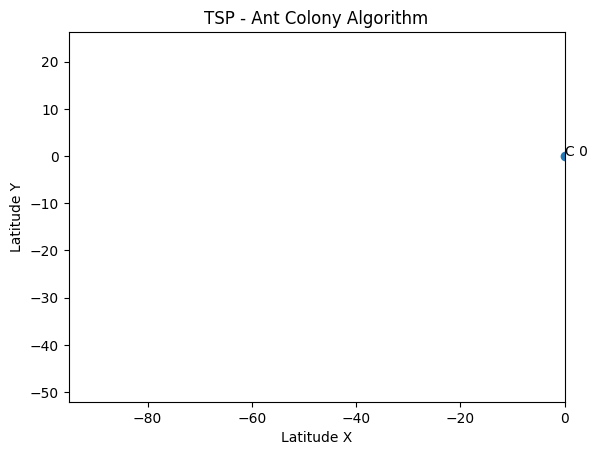

In [24]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import pyplot as plt

x = []
y = []
for s in best.val:
    x.append(s.x)
    y.append(s.y)
x.append(best.val[0].x)
y.append(best.val[0].y)

# find fig limits
xl = max(x) + 0.2*max(x)
yl = max(y) + 0.2*max(y)
xlm = min(x) + 0.2*min(x)
ylm = min(y) + 0.2*min(y)

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.plot(x[:i+1], y[:i+1], marker = 'o')
    for j, (x_val, y_val) in enumerate(zip(x[:i+1], y[:i+1])):
        ax.annotate(f'C {j}', (x_val, y_val))

    plt.xlim(xlm, xl)
    plt.ylim(ylm, yl)

    # Set plot title and axis labels
    ax.set_title('TSP - Ant Colony Algorithm')
    ax.set_xlabel('Latitude X')
    ax.set_ylabel('Latitude Y')

ani = FuncAnimation(fig, animate, frames=20, interval=300, repeat=False)
HTML(ani.to_jshtml())